In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import botorch
import gpytorch
from tqdm import tqdm

In [2]:
# ignore warnings in this notebook
import warnings
warnings.filterwarnings('ignore')

## Utilities and GPModel class

In [3]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1  # to be compatible with botorch

    def __init__(self, train_x, train_y, likelihood, likelihood_noise=1e-4):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=2)
        )
        self.likelihood.noise = likelihood_noise

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [4]:
def visualize_ground_truth_and_acquisition(ys, train_x, acquisition_score, next_x):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot ground truth data
    im1 = axs[0].imshow(ys, extent=[0, 2, 0, 2])
    #axs[0].grid(True)  # Add grid
    axs[0].scatter(train_x[:, 0], train_x[:, 1], color='black', marker='+', label='observations')
    axs[0].set_title('Ground Truth')
    
    # Plot acquisition function
    im2 = axs[1].imshow(acquisition_score, extent=[0, 2, 0, 2])
    #axs[1].grid(True)  # Add grid
    axs[1].scatter(train_x[:, 0], train_x[:, 1], color='black', marker='+', label='observations')
    axs[1].scatter([next_x[0][0]], [next_x[0][1]], color='red', marker='*', s=100, label='next_x')
    axs[1].set_title('Acquisition Function')
    
    # Add colorbar next to subplots
    plt.colorbar(im1, ax=axs[0])
    plt.colorbar(im2, ax=axs[1])
    
    # Add legend
    axs[0].legend()
    axs[1].legend()
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [5]:
def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    
    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [6]:
def compute_acquisition_score_and_next_x(xs, policy):
    acquisition_score = policy(xs.unsqueeze(2)).detach().numpy()

    next_x, _ = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[0.0, 0.0], [2.0, 2.0]]),
        q=1,
        num_restarts=40,
        raw_samples=100,
    )
    return acquisition_score, next_x

In [7]:
def Bayes_opt_loop(xs, train_x, train_y, ys, policy_type, f, visualize=True, num_queries=10):
    print(f'Bayes opt loop for policy type: {policy_type}')
    return_dict = {
        'incumbents': [],
        'incumbent_values': [],
    }
    for i in range(num_queries):
        if visualize == True:
            print("iteration", i)
            print("incumbent", train_x[train_y.argmax()], train_y.max())
            print(f'train data size: {train_x.shape[0]}')

        # fit GP model
        model, likelihood = fit_gp_model(train_x, train_y)

        # define the policy class
        if policy_type == 'PoI':
            policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
                model, best_f=train_y.max()
            )
        elif policy_type == 'epsilon-PoI':
            policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
                model, best_f=train_y.max()*1.1
            )
        elif policy_type == 'EI':
            policy = botorch.acquisition.analytic.ExpectedImprovement(
                model, best_f=train_y.max()
            )
        else:
            raise ValueError(f'Unknown policy type: {policy_type}')
        
        # compute acquisition score and next_x
        acquisition_score, next_x = compute_acquisition_score_and_next_x(xs, policy)

        # visualize ground truth and acquisition function
        if visualize:
            visualize_ground_truth_and_acquisition(ys, train_x, acquisition_score, next_x)

        # update the dataset
        next_y = f(next_x)
        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])
        
        if visualize == True:
            print(f'next_x: {next_x}, next_y: {next_y}')
            print('#############################################')

        # save the incumbent
        return_dict['incumbents'].append(train_x[train_y.argmax()])
        return_dict['incumbent_values'].append(train_y.max())

    # return the incumbent and incumbent values respective lists
    return return_dict

## Objective function and data

In [8]:
def f(x):
    return (
        torch.sin(5 * x[..., 0] / 2 - 2.5) * torch.cos(2.5 - 5 * x[..., 1])
        + (5 * x[..., 1] / 2 + 0.5) ** 2 / 10
    ) / 5 + 0.2

In [9]:
# Define the grid
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
xs = np.stack((X, Y), axis=-1)
xs = torch.tensor(xs, dtype=torch.float)

# Evaluate the function on the grid
ys = f(xs)


In [10]:
# sample training data
#train_x = torch.rand(100, 2) * 2

# Compute train_y
#train_y = f(train_x).detach()

train_x = torch.tensor([[1.0, 1.0]])
train_y = f(train_x).detach()

# convert both train_x and train_y to float tensor
train_x = train_x.float()
train_y = train_y.float()

In [11]:
train_x.shape

torch.Size([1, 2])

## Experiments

### PoI

Bayes opt loop for policy type: PoI
iteration 0
incumbent tensor([1., 1.]) tensor(0.3800)
train data size: 1


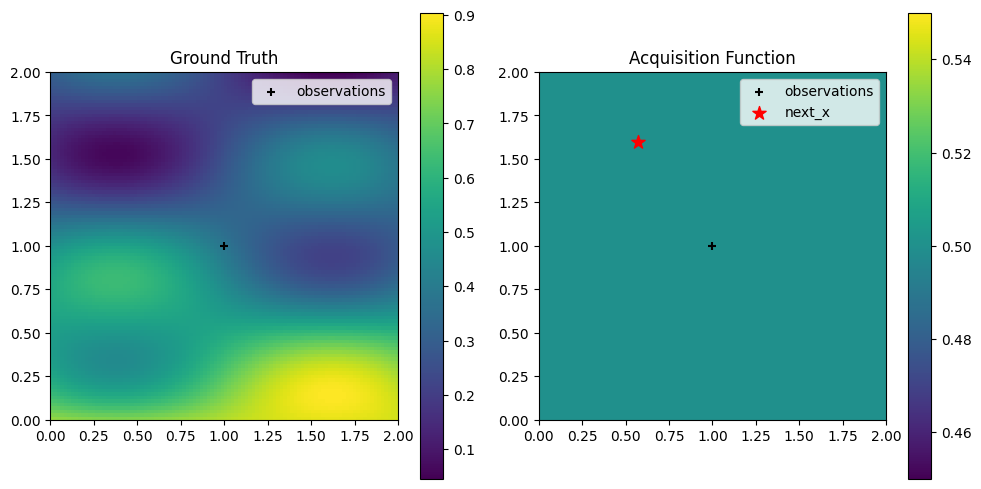

next_x: tensor([[0.5700, 1.5977]]), next_y: tensor([0.4807])
#############################################
iteration 1
incumbent tensor([0.5700, 1.5977]) tensor(0.4807)
train data size: 2


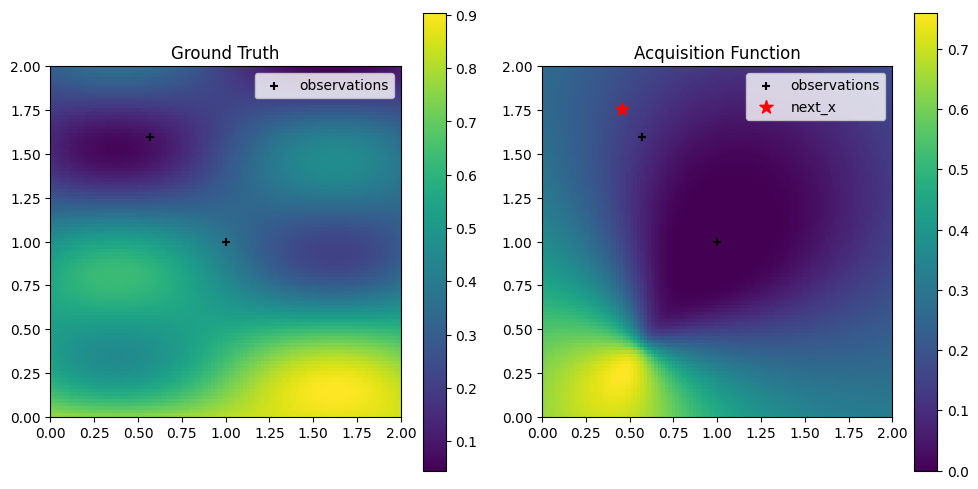

next_x: tensor([[0.4538, 1.7591]]), next_y: tensor([0.4840])
#############################################
iteration 2
incumbent tensor([0.4538, 1.7591]) tensor(0.4840)
train data size: 3


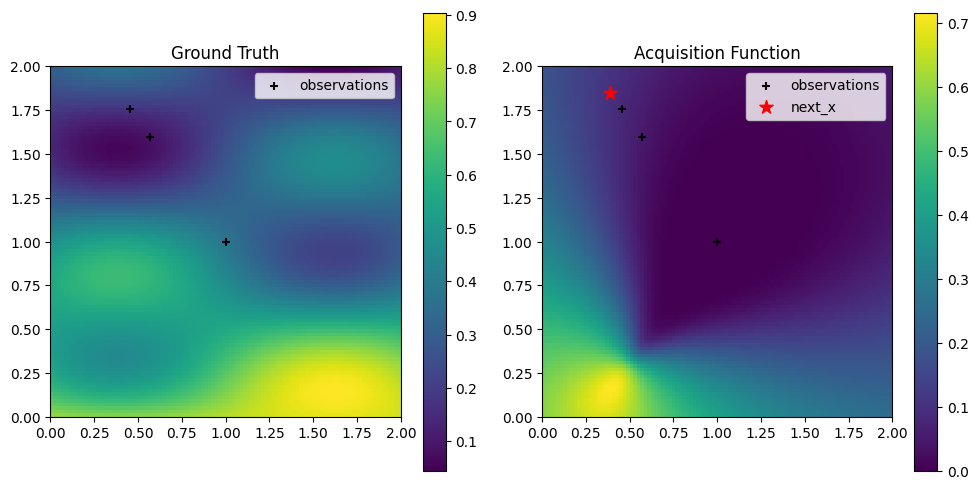

next_x: tensor([[0.3883, 1.8503]]), next_y: tensor([0.5471])
#############################################
iteration 3
incumbent tensor([0.3883, 1.8503]) tensor(0.5471)
train data size: 4


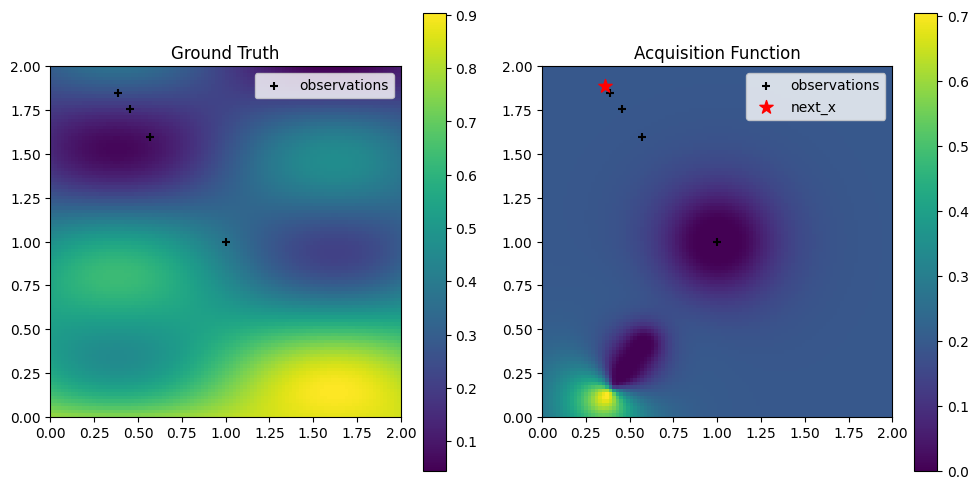

next_x: tensor([[0.3606, 1.8887]]), next_y: tensor([0.5874])
#############################################
iteration 4
incumbent tensor([0.3606, 1.8887]) tensor(0.5874)
train data size: 5


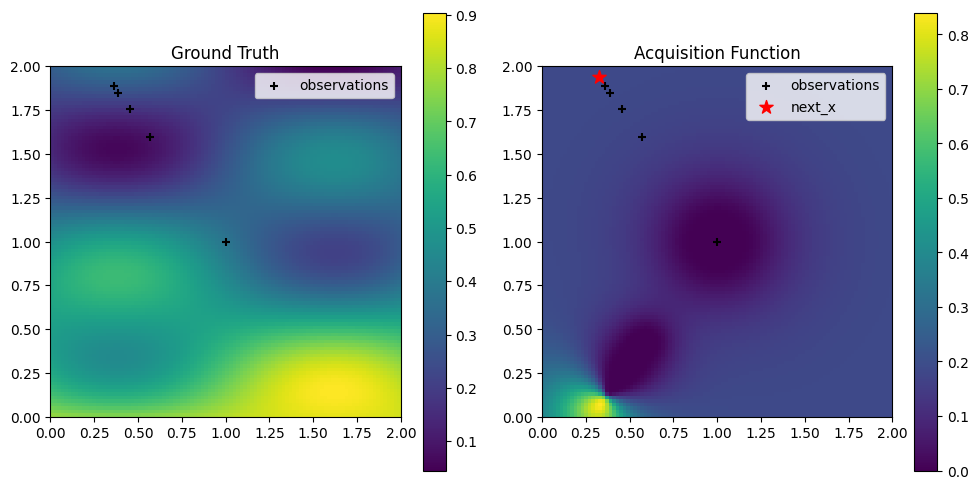

next_x: tensor([[0.3241, 1.9395]]), next_y: tensor([0.6510])
#############################################
iteration 5
incumbent tensor([0.3241, 1.9395]) tensor(0.6510)
train data size: 6


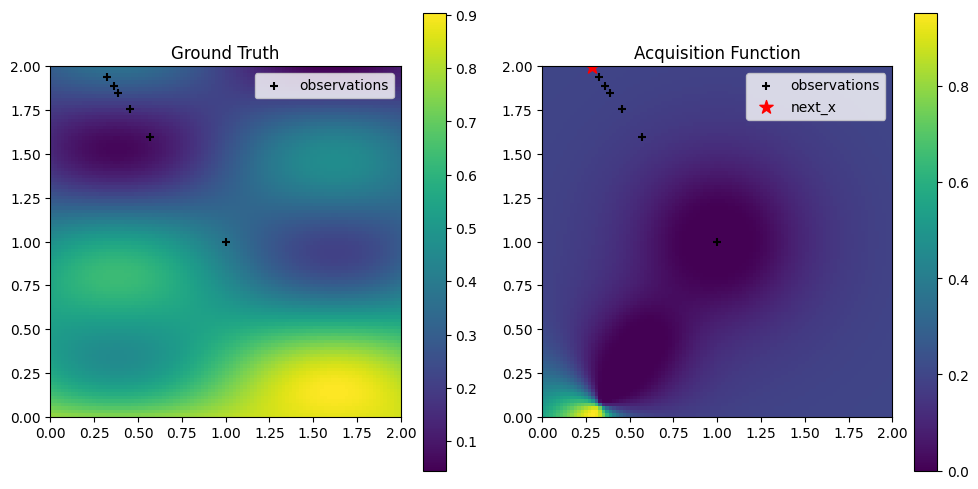

next_x: tensor([[0.2850, 1.9939]]), next_y: tensor([0.7284])
#############################################
iteration 6
incumbent tensor([0.2850, 1.9939]) tensor(0.7284)
train data size: 7


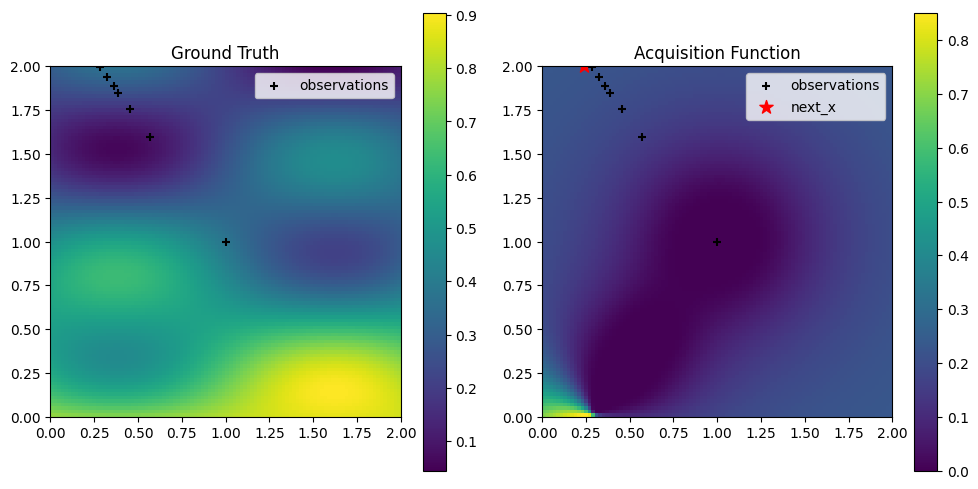

next_x: tensor([[0.2372, 2.0000]]), next_y: tensor([0.7396])
#############################################
iteration 7
incumbent tensor([0.2372, 2.0000]) tensor(0.7396)
train data size: 8


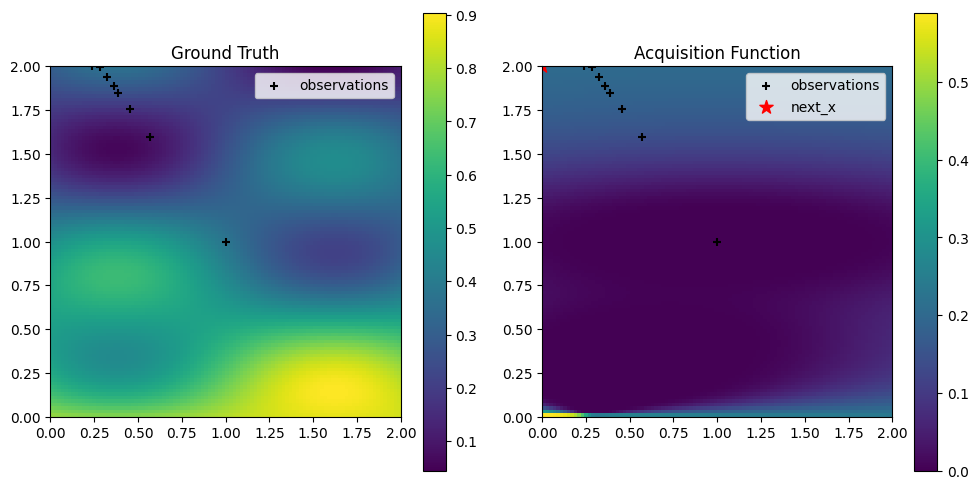

next_x: tensor([[0., 2.]]), next_y: tensor([0.7635])
#############################################
iteration 8
incumbent tensor([0., 2.]) tensor(0.7635)
train data size: 9


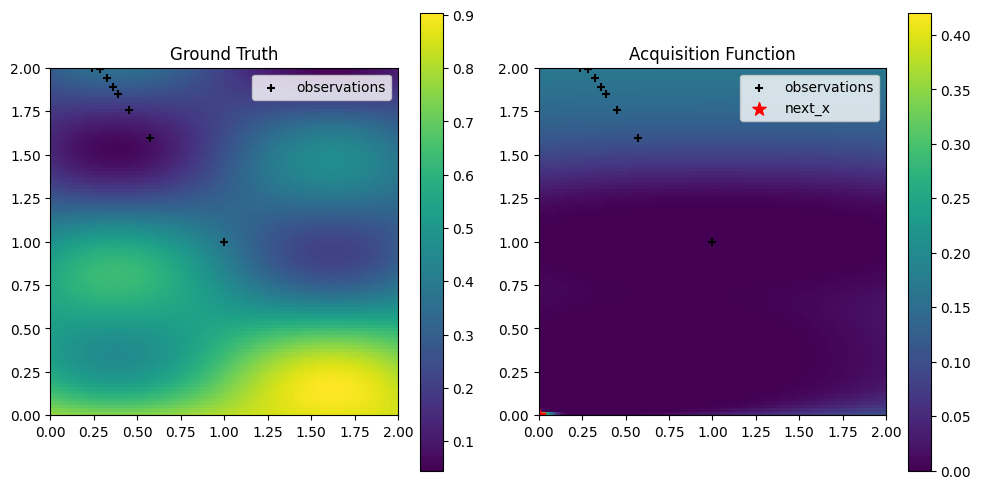

next_x: tensor([[0., 0.]]), next_y: tensor([0.3009])
#############################################
iteration 9
incumbent tensor([0., 2.]) tensor(0.7635)
train data size: 10


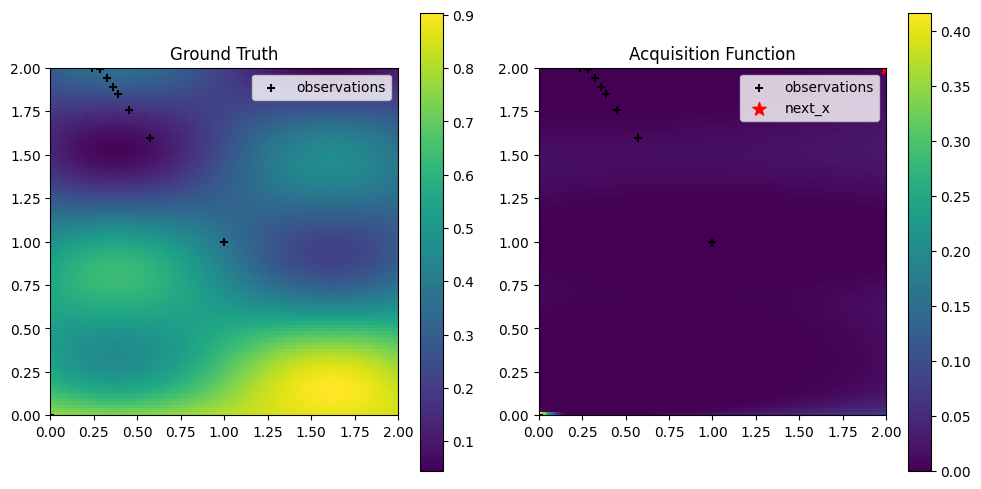

next_x: tensor([[2., 2.]]), next_y: tensor([0.8465])
#############################################


In [12]:
poi_bayes_opt_loop = Bayes_opt_loop(xs, train_x, train_y, ys, f=f, policy_type='PoI', num_queries=10)

### Modified PoI

Bayes opt loop for policy type: epsilon-PoI
iteration 0
incumbent tensor([1., 1.]) tensor(0.3800)
train data size: 1


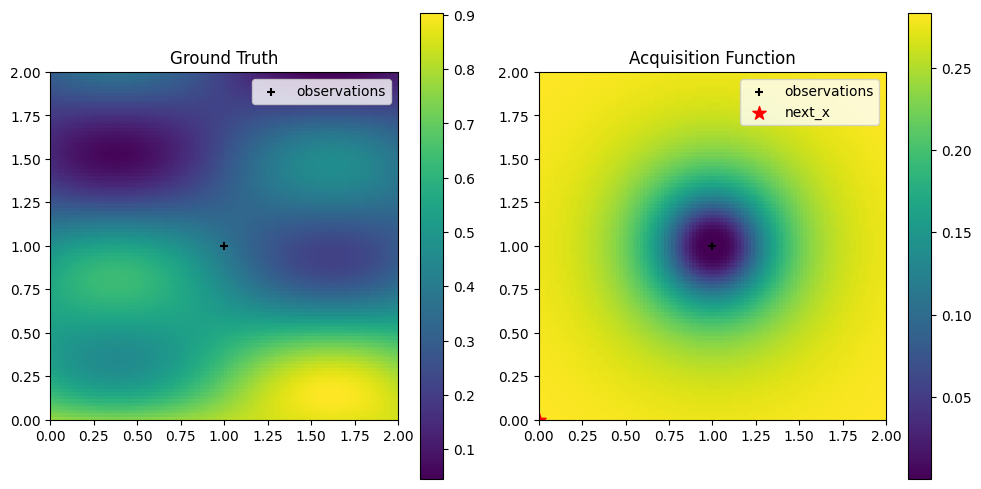

next_x: tensor([[0., 0.]]), next_y: tensor([0.3009])
#############################################
iteration 1
incumbent tensor([1., 1.]) tensor(0.3800)
train data size: 2


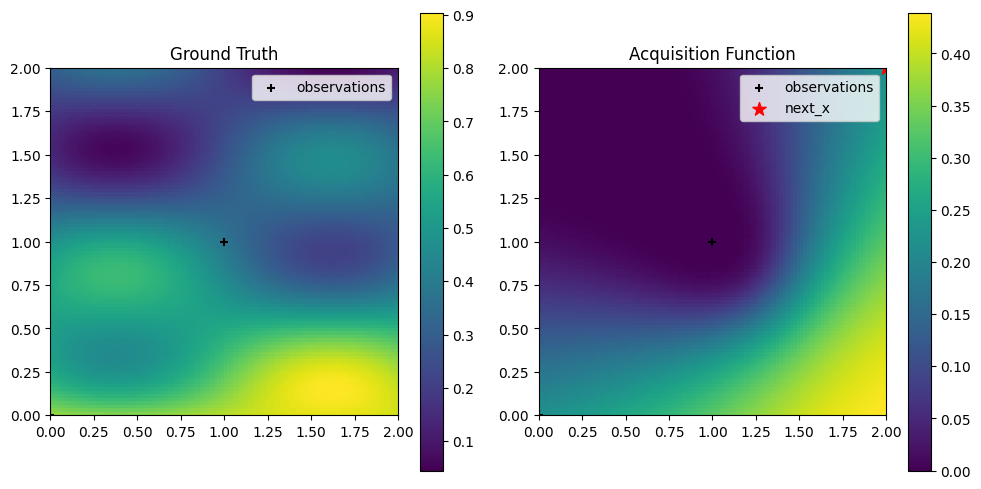

next_x: tensor([[2., 2.]]), next_y: tensor([0.8465])
#############################################
iteration 2
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 3


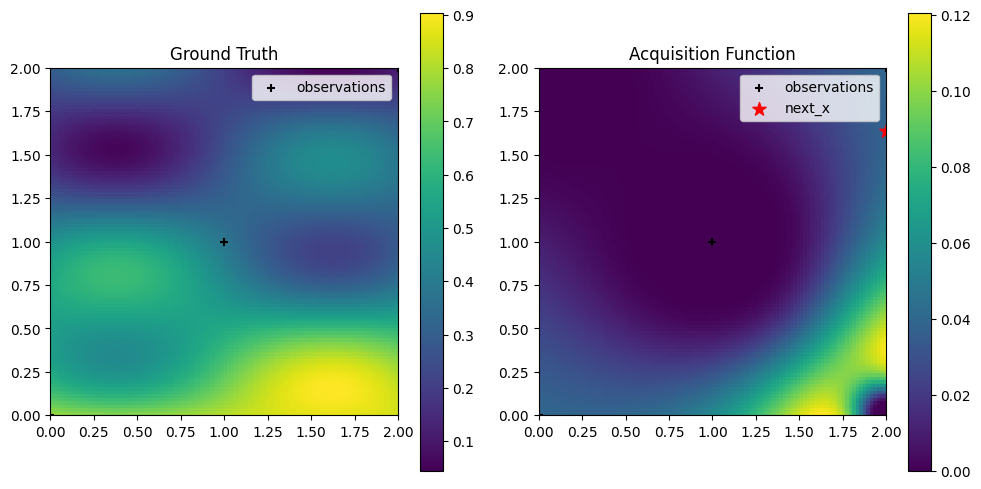

next_x: tensor([[2.0000, 1.6344]]), next_y: tensor([0.7187])
#############################################
iteration 3
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 4


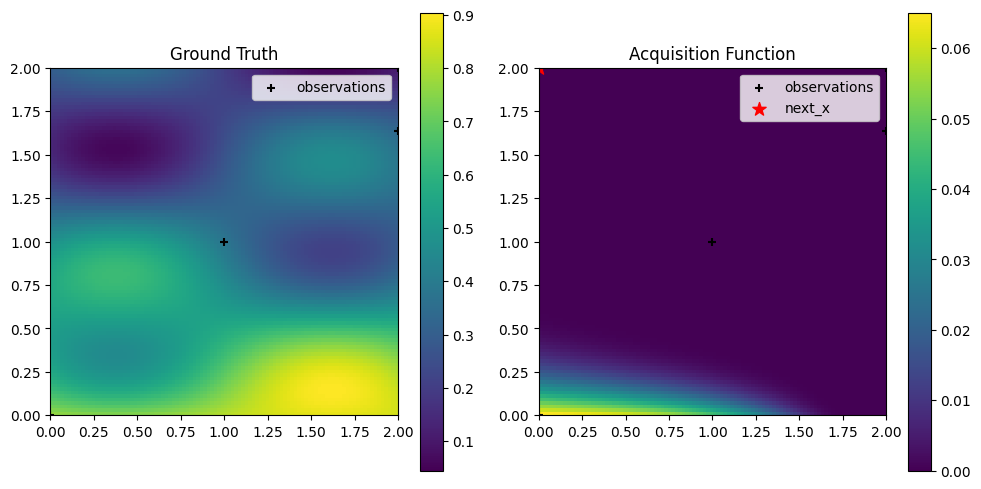

next_x: tensor([[0., 2.]]), next_y: tensor([0.7635])
#############################################
iteration 4
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 5


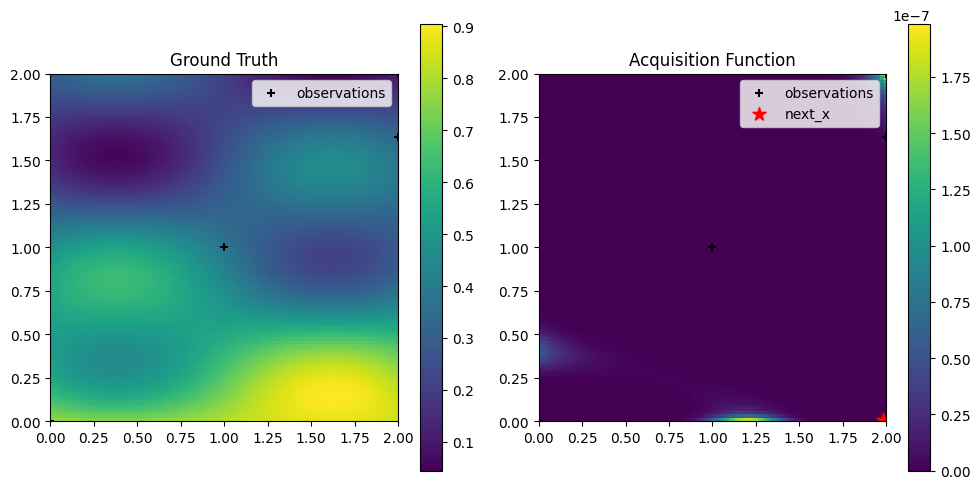

next_x: tensor([[1.9825, 0.0046]]), next_y: tensor([0.1056])
#############################################
iteration 5
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 6


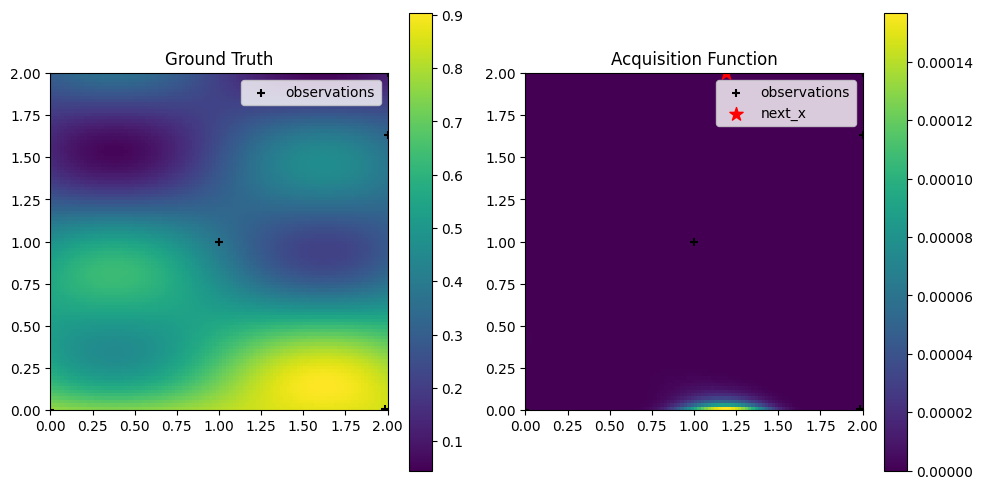

next_x: tensor([[1.1890, 2.0000]]), next_y: tensor([0.8366])
#############################################
iteration 6
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 7


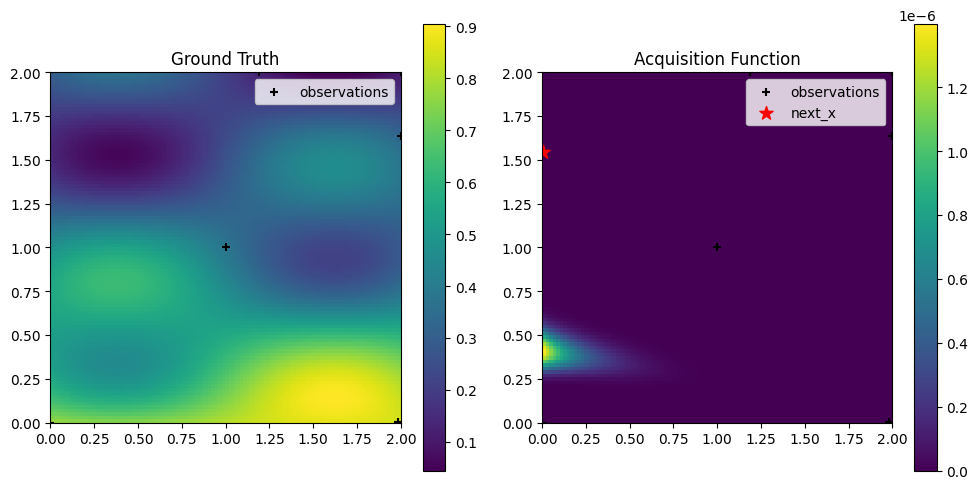

next_x: tensor([[0.0044, 1.5467]]), next_y: tensor([0.5209])
#############################################
iteration 7
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 8


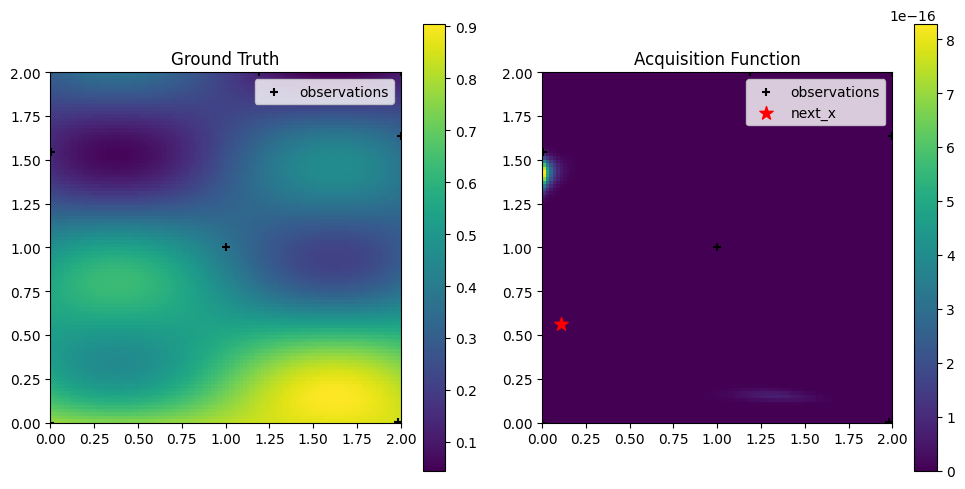

next_x: tensor([[0.1062, 0.5619]]), next_y: tensor([0.1225])
#############################################
iteration 8
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 9


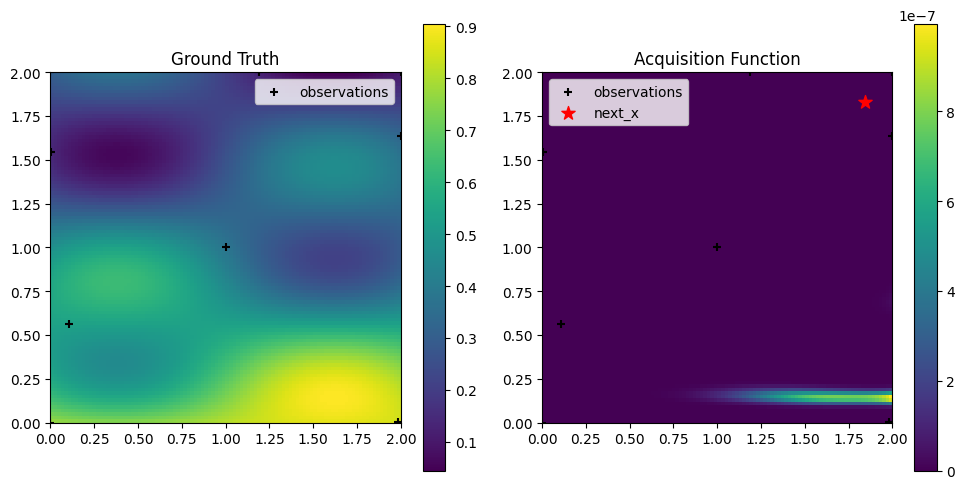

next_x: tensor([[1.8441, 1.8317]]), next_y: tensor([0.8756])
#############################################
iteration 9
incumbent tensor([1.8441, 1.8317]) tensor(0.8756)
train data size: 10


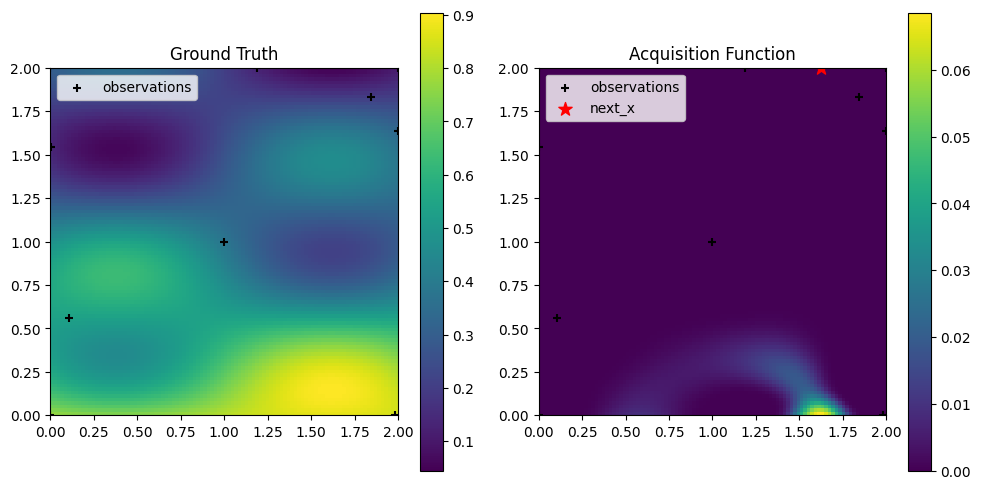

next_x: tensor([[1.6226, 2.0000]]), next_y: tensor([0.8743])
#############################################


In [13]:
ep_poi_bayes_opt_loop = Bayes_opt_loop(xs, train_x, train_y, ys, f=f, policy_type='epsilon-PoI', num_queries=10)

### Expected Improvement EI

Bayes opt loop for policy type: EI
iteration 0
incumbent tensor([1., 1.]) tensor(0.3800)
train data size: 1


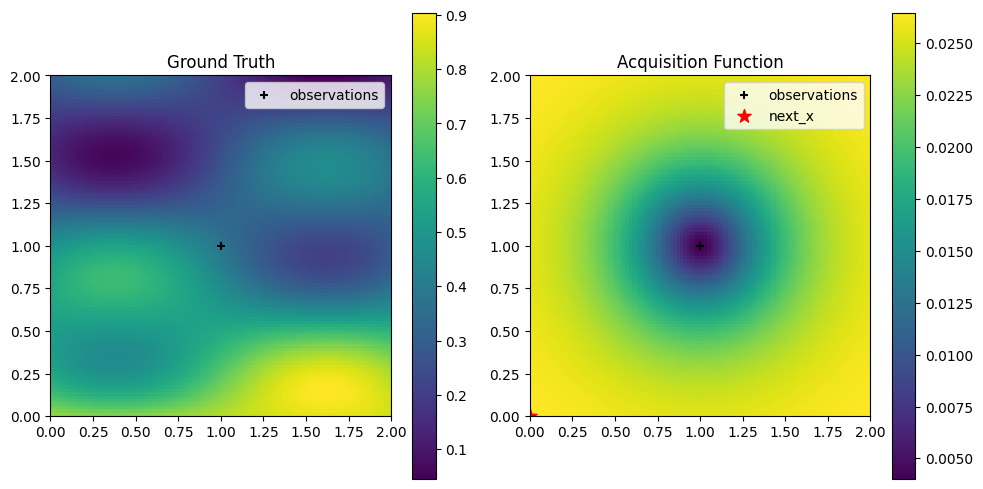

next_x: tensor([[0., 0.]]), next_y: tensor([0.3009])
#############################################
iteration 1
incumbent tensor([1., 1.]) tensor(0.3800)
train data size: 2


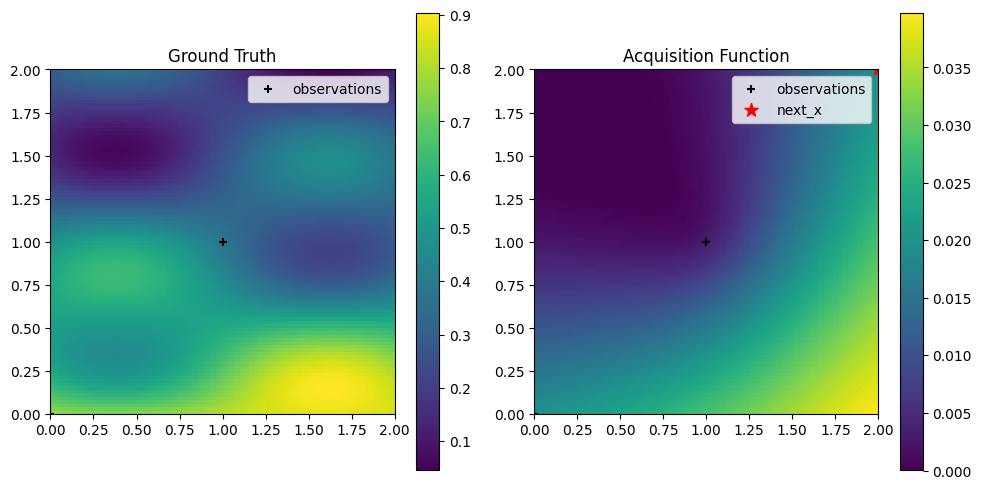

next_x: tensor([[2., 2.]]), next_y: tensor([0.8465])
#############################################
iteration 2
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 3


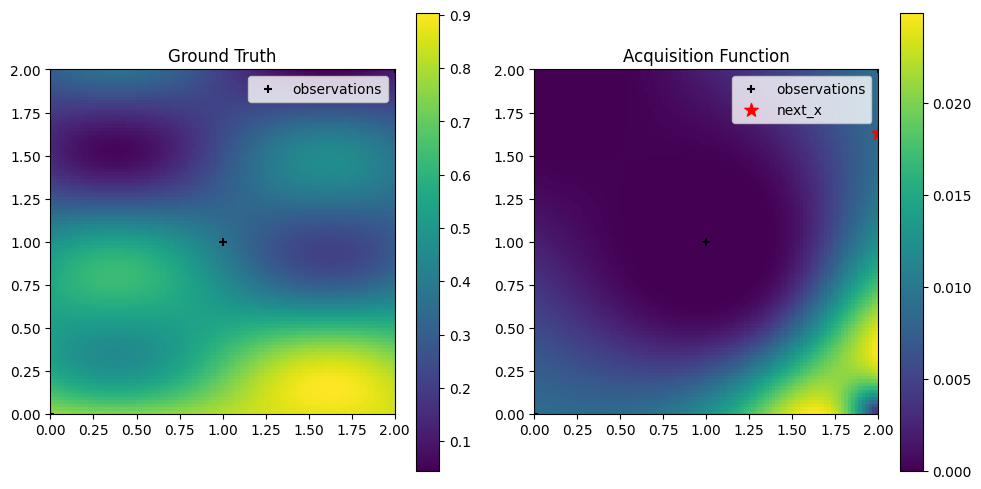

next_x: tensor([[2.0000, 1.6296]]), next_y: tensor([0.7148])
#############################################
iteration 3
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 4


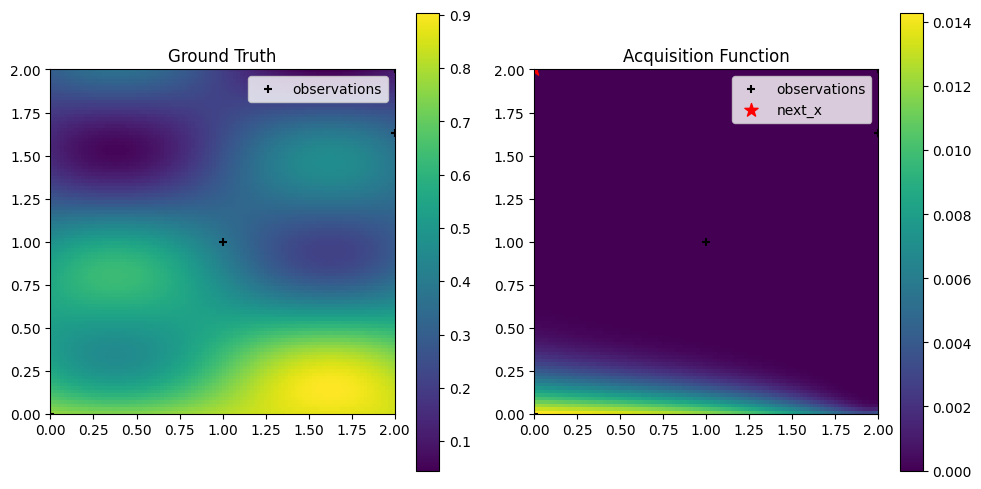

next_x: tensor([[0., 2.]]), next_y: tensor([0.7635])
#############################################
iteration 4
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 5


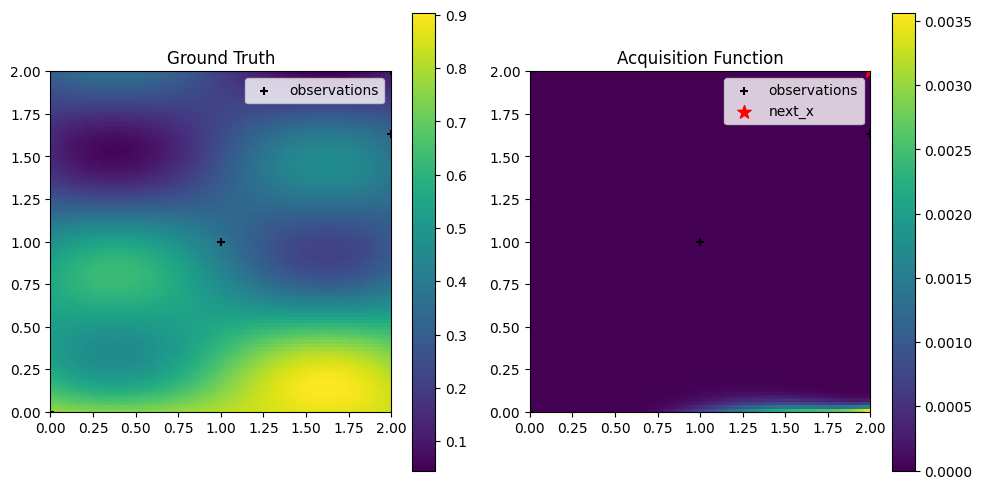

next_x: tensor([[2., 2.]]), next_y: tensor([0.8465])
#############################################
iteration 5
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 6


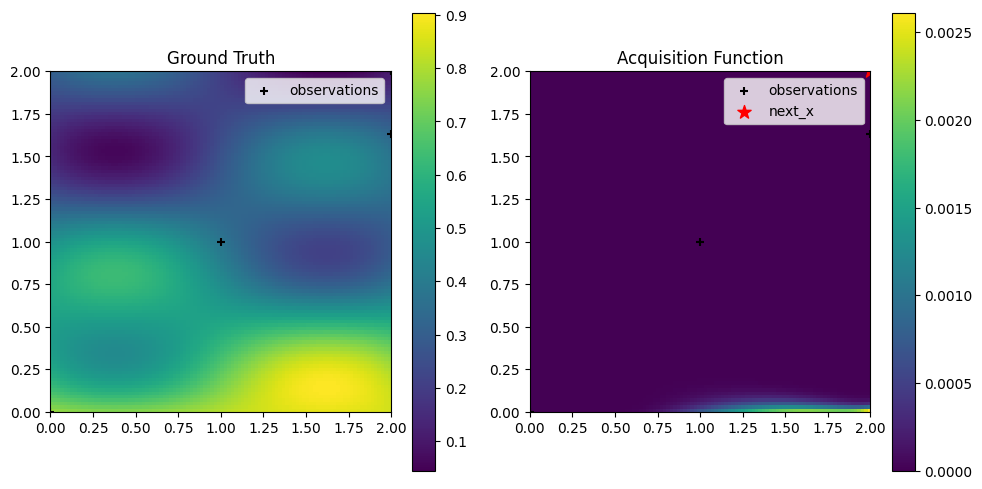

next_x: tensor([[2., 2.]]), next_y: tensor([0.8465])
#############################################
iteration 6
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 7


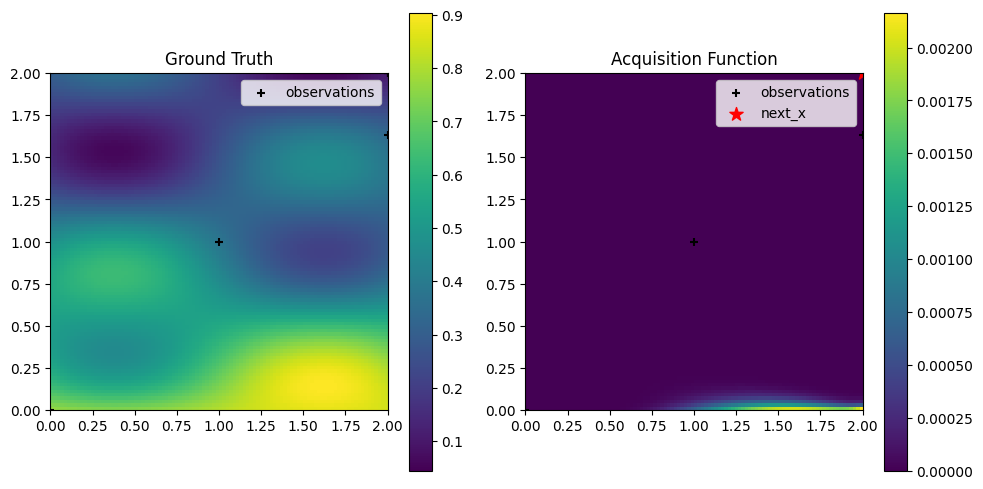

next_x: tensor([[2., 2.]]), next_y: tensor([0.8465])
#############################################
iteration 7
incumbent tensor([2., 2.]) tensor(0.8465)
train data size: 8


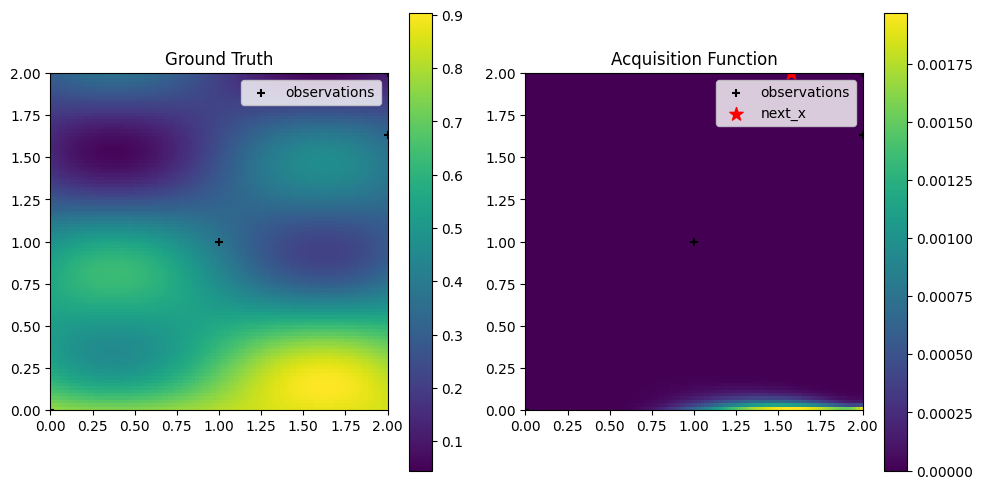

next_x: tensor([[1.5751, 2.0000]]), next_y: tensor([0.8737])
#############################################
iteration 8
incumbent tensor([1.5751, 2.0000]) tensor(0.8737)
train data size: 9


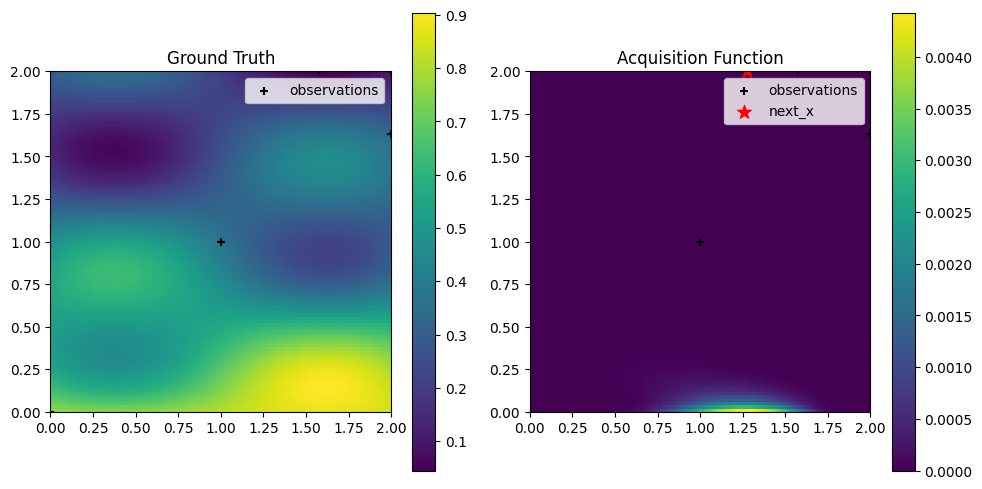

next_x: tensor([[1.2750, 2.0000]]), next_y: tensor([0.8490])
#############################################
iteration 9
incumbent tensor([1.5751, 2.0000]) tensor(0.8737)
train data size: 10


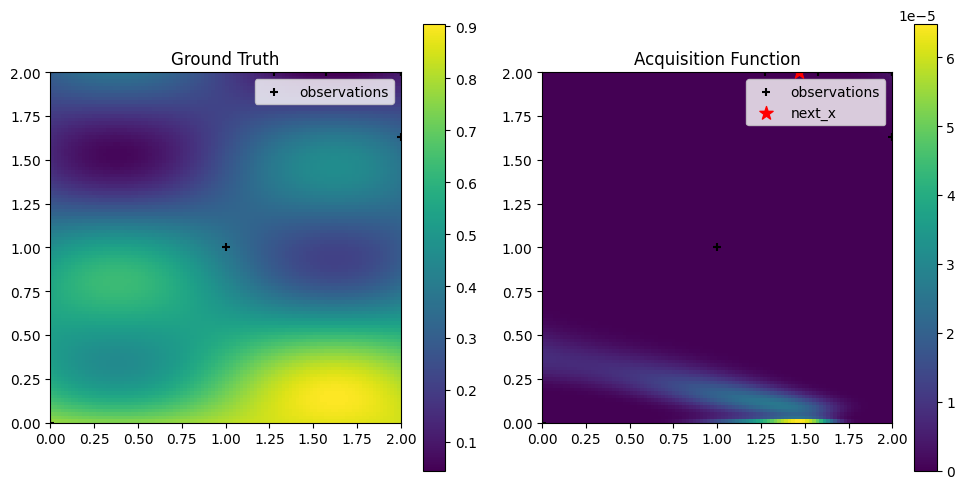

next_x: tensor([[1.4675, 2.0000]]), next_y: tensor([0.8688])
#############################################


In [14]:
ep_poi_bayes_opt_loop = Bayes_opt_loop(xs, train_x, train_y, ys, f=f, policy_type='EI', num_queries=10)

## Comparison between policies after multiple bayes opt runs

In [15]:
num_runs = 20
num_queries = 20

policies_mean_std_values = {}

# Initialize matrix to store incumbent values
incumbent_values_matrix = np.zeros((num_runs, num_queries))

# Run Bayes opt loops for each policy
for policy in ['PoI', 'epsilon-PoI', 'EI']:
    print('#############################################')
    print(f'Running Bayes opt loop for policy: {policy}')
    for run in tqdm(range(num_runs)):
        # Run Bayes opt loop
        bayes_opt_loop = Bayes_opt_loop(xs, train_x, train_y, ys, f=f, policy_type=policy, num_queries=num_queries, visualize=False)
        incumbent_values_matrix[run] = bayes_opt_loop['incumbent_values']

        policies_mean_std_values[policy] = {
            'mean': np.mean(incumbent_values_matrix, axis=0),
            'std': np.std(incumbent_values_matrix, axis=0),
        }

#############################################
Running Bayes opt loop for policy: PoI


  0%|          | 0/20 [00:00<?, ?it/s]

Bayes opt loop for policy type: PoI


  5%|▌         | 1/20 [00:20<06:27, 20.42s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 10%|█         | 2/20 [00:41<06:18, 21.00s/it]

Bayes opt loop for policy type: PoI


 15%|█▌        | 3/20 [01:03<06:02, 21.31s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 20%|██        | 4/20 [01:23<05:35, 20.94s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 25%|██▌       | 5/20 [01:43<05:06, 20.42s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 30%|███       | 6/20 [02:03<04:45, 20.39s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 35%|███▌      | 7/20 [02:26<04:36, 21.24s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[Optimizati

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:389: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 50%|█████     | 10/20 [03:35<03:42, 22.24s/it]

Bayes opt loop for policy type: PoI


 55%|█████▌    | 11/20 [03:57<03:19, 22.18s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 60%|██████    | 12/20 [04:21<03:02, 22.79s/it]

Bayes opt loop for policy type: PoI


 65%|██████▌   | 13/20 [04:40<02:31, 21.64s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 70%|███████   | 14/20 [05:02<02:10, 21.80s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 75%|███████▌  | 15/20 [05:22<01:46, 21.24s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[Optimizati

Bayes opt loop for policy type: PoI


 85%|████████▌ | 17/20 [06:09<01:06, 22.02s/it]

Bayes opt loop for policy type: PoI


 90%|█████████ | 18/20 [06:28<00:42, 21.40s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 95%|█████████▌| 19/20 [06:53<00:22, 22.46s/it]

Bayes opt loop for policy type: PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[Optimizati

#############################################
Running Bayes opt loop for policy: epsilon-PoI


  0%|          | 0/20 [00:00<?, ?it/s]

Bayes opt loop for policy type: epsilon-PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:389: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.

Bayes opt loop for policy type: epsilon-PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 10%|█         | 2/20 [00:41<06:14, 20.78s/it]

Bayes opt loop for policy type: epsilon-PoI


 15%|█▌        | 3/20 [01:00<05:38, 19.94s/it]

Bayes opt loop for policy type: epsilon-PoI


 20%|██        | 4/20 [01:20<05:17, 19.85s/it]

Bayes opt loop for policy type: epsilon-PoI


 25%|██▌       | 5/20 [01:38<04:49, 19.29s/it]

Bayes opt loop for policy type: epsilon-PoI


 30%|███       | 6/20 [01:57<04:29, 19.25s/it]

Bayes opt loop for policy type: epsilon-PoI


 35%|███▌      | 7/20 [02:18<04:16, 19.71s/it]

Bayes opt loop for policy type: epsilon-PoI


 40%|████      | 8/20 [02:37<03:53, 19.43s/it]

Bayes opt loop for policy type: epsilon-PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 45%|████▌     | 9/20 [02:57<03:35, 19.63s/it]

Bayes opt loop for policy type: epsilon-PoI


 50%|█████     | 10/20 [03:16<03:15, 19.54s/it]

Bayes opt loop for policy type: epsilon-PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 55%|█████▌    | 11/20 [03:36<02:57, 19.75s/it]

Bayes opt loop for policy type: epsilon-PoI


 60%|██████    | 12/20 [03:57<02:39, 19.95s/it]

Bayes opt loop for policy type: epsilon-PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[Optimizati

Bayes opt loop for policy type: epsilon-PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 70%|███████   | 14/20 [04:39<02:02, 20.40s/it]

Bayes opt loop for policy type: epsilon-PoI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 75%|███████▌  | 15/20 [04:59<01:41, 20.29s/it]

Bayes opt loop for policy type: epsilon-PoI


 80%|████████  | 16/20 [05:18<01:20, 20.11s/it]

Bayes opt loop for policy type: epsilon-PoI


 85%|████████▌ | 17/20 [05:37<00:59, 19.79s/it]

Bayes opt loop for policy type: epsilon-PoI


 90%|█████████ | 18/20 [05:58<00:39, 19.97s/it]

Bayes opt loop for policy type: epsilon-PoI


 95%|█████████▌| 19/20 [06:17<00:19, 19.66s/it]

Bayes opt loop for policy type: epsilon-PoI


100%|██████████| 20/20 [06:36<00:00, 19.82s/it]


#############################################
Running Bayes opt loop for policy: EI


  0%|          | 0/20 [00:00<?, ?it/s]

Bayes opt loop for policy type: EI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
  5%|▌         | 1/20 [00:19<06:15, 19.77s/it]

Bayes opt loop for policy type: EI


 10%|█         | 2/20 [00:39<06:00, 20.03s/it]

Bayes opt loop for policy type: EI


 15%|█▌        | 3/20 [01:00<05:44, 20.28s/it]

Bayes opt loop for policy type: EI


 20%|██        | 4/20 [01:21<05:27, 20.49s/it]

Bayes opt loop for policy type: EI


 25%|██▌       | 5/20 [01:42<05:08, 20.55s/it]

Bayes opt loop for policy type: EI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 30%|███       | 6/20 [02:03<04:53, 21.00s/it]

Bayes opt loop for policy type: EI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 35%|███▌      | 7/20 [02:23<04:28, 20.64s/it]

Bayes opt loop for policy type: EI


 40%|████      | 8/20 [02:44<04:09, 20.80s/it]

Bayes opt loop for policy type: EI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 45%|████▌     | 9/20 [03:06<03:51, 21.06s/it]

Bayes opt loop for policy type: EI


 50%|█████     | 10/20 [03:27<03:30, 21.00s/it]

Bayes opt loop for policy type: EI


 55%|█████▌    | 11/20 [03:47<03:07, 20.84s/it]

Bayes opt loop for policy type: EI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 60%|██████    | 12/20 [04:08<02:45, 20.71s/it]

Bayes opt loop for policy type: EI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 65%|██████▌   | 13/20 [04:30<02:27, 21.07s/it]

Bayes opt loop for policy type: EI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 70%|███████   | 14/20 [04:53<02:09, 21.62s/it]

Bayes opt loop for policy type: EI


/home/vscode/.local/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
 75%|███████▌  | 15/20 [05:15<01:48, 21.79s/it]

Bayes opt loop for policy type: EI


 80%|████████  | 16/20 [05:37<01:27, 21.86s/it]

Bayes opt loop for policy type: EI


 85%|████████▌ | 17/20 [05:58<01:05, 21.70s/it]

Bayes opt loop for policy type: EI


 90%|█████████ | 18/20 [06:19<00:42, 21.46s/it]

Bayes opt loop for policy type: EI


 95%|█████████▌| 19/20 [06:40<00:21, 21.36s/it]

Bayes opt loop for policy type: EI


100%|██████████| 20/20 [07:02<00:00, 21.11s/it]


In [16]:
policies_mean_std_values

{'PoI': {'mean': array([0.47829704, 0.52905664, 0.56014896, 0.58675415, 0.63038965,
         0.66137903, 0.67963882, 0.68771484, 0.70564829, 0.71417072,
         0.72449876, 0.73801889, 0.74117661, 0.74364946, 0.74420885,
         0.74425829, 0.74603515, 0.74725719, 0.74792311, 0.7483738 ]),
  'std': array([0.13966526, 0.14674193, 0.15605869, 0.15035361, 0.14523614,
         0.1547501 , 0.15101149, 0.14657519, 0.15140739, 0.1530526 ,
         0.15520235, 0.13949784, 0.13595843, 0.13321295, 0.13271803,
         0.13267892, 0.13080707, 0.12963354, 0.12906039, 0.12864218])},
 'epsilon-PoI': {'mean': array([0.55414903, 0.71390595, 0.75093106, 0.7565266 , 0.77987883,
         0.80899574, 0.80914862, 0.82207027, 0.87217196, 0.87352552,
         0.87959186, 0.88150181, 0.8894091 , 0.89142439, 0.89230094,
         0.89362705, 0.89378552, 0.89538821, 0.89666255, 0.89666255]),
  'std': array([0.21479612, 0.16351555, 0.13682419, 0.14206177, 0.13349995,
         0.11477394, 0.11451042, 0.10609174,

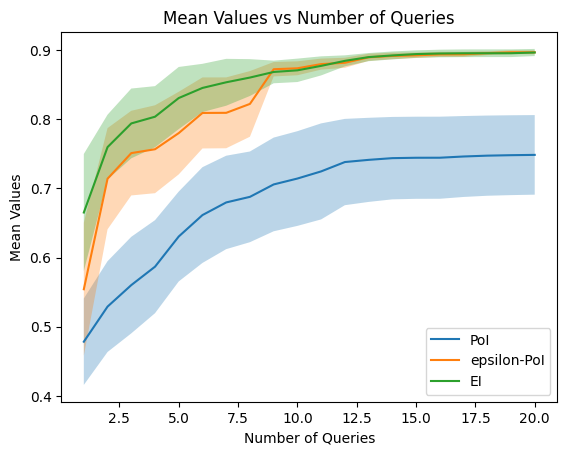

In [23]:
# Plot mean curve with confidence intervals for each policy
for policy, values in policies_mean_std_values.items():
    mean_values = values['mean']
    std_values = values['std']
    x = np.arange(1, num_queries + 1)
    
    # Plot mean curve
    plt.plot(x, mean_values, label=policy)
    
    # Plot confidence intervals as shaded areas
    plt.fill_between(x, mean_values - 2*std_values/np.sqrt(num_runs), mean_values + 2*std_values/np.sqrt(num_runs), alpha=0.3)

# Add labels and title to the plot
plt.xlabel('Number of Queries')
plt.ylabel('Mean Values')
plt.title('Mean Values vs Number of Queries')

# Add legend
plt.legend()

# Show the plot
plt.show()